# About

This notebook is a Proof of Concept of machine learning application to predict desert items in ComprasGov.

# Imports

In [68]:
# Installing Required Libraries
# %pip install pandas numpy matplotlib seaborn sqlalchemy scikit-learn plotly psycopg2 nbformat
#      scipy xgboost lightgbm catboost tpot sweetviz torch 

# Importing Required Libraries
import pandas as pd
import numpy as np
import sweetviz as sv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
from scipy import stats
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from ydata_profiling import ProfileReport

# import seaborn as sns
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from tpot import TPOTClassifier

# Importing User Sensible Data
from sql.postgres_connection import (dbname, password, host, port, database)
from sql.comprasgov_poc_item_deserto_sql import (full_sql_query, train_sql_query, test_sql_query)

# Suppress FutureWarning from sweetviz
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data

## Database Connection

In [2]:
# Database Connection Function
def read_data_from_postgres(query):
    try:
        engine = create_engine(f'postgresql://{dbname}:{password}@{host}:{port}/{database}')
        df = pd.read_sql_query(query, engine)
        
    except Exception as e:
        print("An error occurred:", e)
        
        
    return df

# Test Connection
df = read_data_from_postgres(full_sql_query)
# df = read_data_from_postgres(train_sql_query)
# df = read_data_from_postgres(test_sql_query)

df_original = df.copy()
# df

# Data Exploration

In [3]:
df = df_original.copy()
df.describe(include='all')

,id_item,codigo_modalidade,numero_item,valor_estimado,quantidade_solicitada,it_sg_uf,it_sg_regiao,codigo_item_catalogo,codigo_grupo_secao,codigo_classe_divisao,...,in_pregao,it_no_orgao,it_no_orgao_vinculado,it_no_orgao_superior,nome_grupo_secao,nome_classe_divisao,nome_pdm_grupo,descricao,md_fornec_por_classe,md_fornec_por_pdm
count,410347,410347.000000,410347.000000,3.936300e+05,4.103470e+05,410347,410347,410347,410187,410187,...,410347,410347,410347,410347,410187,410187,410187,410347,410211.000000,409876.000000
unique,410347,NaN,NaN,NaN,NaN,27,5,74182,81,474,...,2,631,115,48,81,474,7645,14554,NaN,NaN
top,120782,NaN,NaN,NaN,NaN,RJ,SE,1627,65,6515,...,False,COMANDO DO EXERCITO,MINISTERIO DEFESA,PRESIDENCIA DA REPUBLICA,"EQUIPAMENTOS E ARTIGOS PARA USO MÉDICO, DENTÁR...","INSTRUMENTOS, EQUIPAMENTOS E SUPRIMENTOS MÉDIC...",SERVIÇOS DE MANUTENÇÃO E REPARO DE PRODUTOS FA...,Fruta,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,80894,157918,1928,99873,35410,...,210503,69571,131478,272380,99873,35410,7401,2790,NaN,NaN
mean,NaN,5.510604,39.821432,2.485155e+04,1.327562e+04,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.464402,3.562057
std,NaN,0.506354,94.439578,2.169473e+06,7.617151e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.033137,1.679919
min,NaN,3.000000,1.000000,0.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.190000,0.060000
25%,NaN,5.000000,3.000000,9.980000e+00,3.000000e+00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.800000,2.470000
50%,NaN,6.000000,12.000000,4.711000e+01,2.000000e+01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.350000,3.360000
75%,NaN,6.000000,39.000000,3.340000e+02,1.500000e+02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.880000,4.320000


In [4]:
# Describe columns types
df.dtypes

id_item                      object
codigo_modalidade             int64
numero_item                   int64
valor_estimado              float64
quantidade_solicitada         int64
it_sg_uf                     object
it_sg_regiao                 object
codigo_item_catalogo         object
codigo_grupo_secao           object
codigo_classe_divisao        object
codigo_pdm_grupo             object
numero_uasg                  object
it_co_orgao                  object
it_co_orgao_vinculado        object
it_co_orgao_superior         object
it_in_tipo_administracao     object
in_orcamento_sigiloso          bool
in_deserto                     bool
in_agrupado                    bool
in_aberto                      bool
in_srp                         bool
in_exclusivo_me_epp            bool
in_federal                     bool
in_poder_executivo             bool
in_servico                     bool
in_pregao                      bool
it_no_orgao                  object
it_no_orgao_vinculado       

in_deserto = False:       382135
in_deserto = True:        28212
Proportion (False/True):  13.55 : 1
Percentage (False/Total): 6.88 %


<Axes: title={'center': 'Count (target)'}, xlabel='in_deserto'>

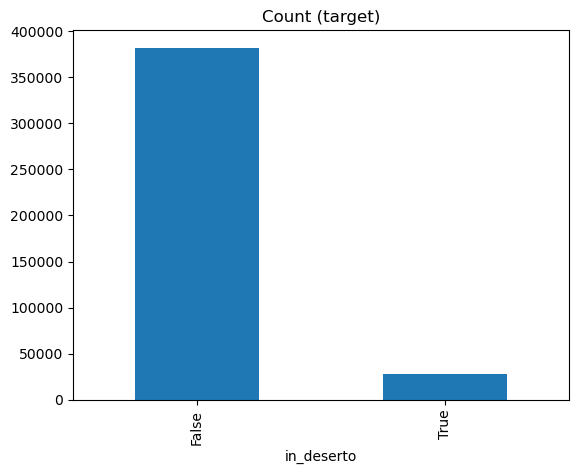

In [5]:
# Stats of target class
in_deserto_count = df.in_deserto.value_counts()
print('in_deserto = False:      ', in_deserto_count.iloc[0])
print('in_deserto = True:       ', in_deserto_count.iloc[1])
print('Proportion (False/True): ', round(in_deserto_count.iloc[0] / in_deserto_count.iloc[1], 2), ': 1')
print('Percentage (False/Total):', round(in_deserto_count.iloc[1] / df.shape[0] * 100, 2), '%')

# Plot target class
in_deserto_count.plot(kind='bar', title='Count (target)')

## Visualizations

In [58]:
# Copy the original dataframe
df = df_original.copy()

# Convert id_item to int
df['id_item'] = df['id_item'].astype(int)

# Filter the dataframe
# df = df[(df['id_item'] > 50000) & (df['id_item'] < 384000)].copy()
df = df[(df['id_item'] > 150000)].copy()

# Create bins for 'id_item'
bins = np.linspace(df['id_item'].min(), df['id_item'].max(), 60)
df['id_item_binned'] = pd.cut(df['id_item'], bins)

# Calculate the percentage of 'True' in 'in_deserto' for each bin
grouped = df.groupby('id_item_binned')['in_deserto'].agg([("Count", "count"), ("True_Count", lambda x: x.sum())])
grouped['in_deserto_true_percentage'] = (grouped['True_Count'] / grouped['Count']) * 100

# Fit a logarithmic curve to the data
x = np.arange(len(grouped))
y = grouped['in_deserto_true_percentage']
coefficients = np.polyfit(x, np.log(y), 1)
poly = np.poly1d(coefficients)
y_fit = np.exp(poly(x))

# Create figure
fig = go.Figure()

# Add bar chart for counts
fig.add_trace(go.Bar(
    x=grouped.index.astype(str),
    y=grouped['Count'],
    name='Count',
    yaxis='y1'
))

# Add line chart for in_deserto_true_percentage
fig.add_trace(go.Scatter(
    x=grouped.index.astype(str),
    y=grouped['in_deserto_true_percentage'],
    name='in_deserto = True (%)',
    yaxis='y2',
    mode='lines+markers',
    line=dict(color='orange', width=3, dash='solid')
))

# Add logarithmic trend line
fig.add_trace(go.Scatter(
    x=grouped.index.astype(str),
    y=y_fit,
    name='Logarithmic Trend Line',
    yaxis='y2',
    mode='lines',
    line=dict(color='lime', width=2, dash='dot'),
))

# Update layout for better visibility
fig.update_layout(
    title='id_item x in_deserto',
    xaxis_title='id_item (binned)',
    yaxis=dict(
        title='Count',
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        )
    ),
    yaxis2=dict(
        title='in_deserto = True (%)',
        overlaying='y',
        side='right',
        titlefont=dict(
            color="#ff7f0e"
        ),
        tickfont=dict(
            color="#ff7f0e"
        )
    ),
    legend=dict(
        orientation='h',
        yanchor='top',
        y=1.25,
        xanchor='right',
        x=1
    ),
    width=1200,
    height=500,
    template='plotly_dark',
)

fig.show()

## Visualization with Pandas Profiling

In [ ]:
df = df_original.copy()

# df_reduced = resample(df, replace=False, n_samples=20000, random_state=42)
# df = df_reduced.copy()

# Generating Pandas Profiling reports
# profile_regular = ProfileReport(df_reduced, title='Pandas Profiling Regular Report', explorative=False, minimal=False)
# profile_regular.to_file(output_file="regular_profile_report.html")

# profile_explorative = ProfileReport(df_reduced, title='Pandas Profiling Explorative Report', explorative=True, minimal=False)
# profile_explorative.to_file(output_file="explorative_profile_report.html")

# profile_sample = ProfileReport(df.sample(n=10000), title='Pandas Profiling Sample Report', html={'style': {'full_width': True}}, sort=None)
# profile_sample.to_file(output_file="sample_profile_report.html")

# profile_minimal = ProfileReport(df, title='Pandas Profiling Minimal Report', explorative=False, minimal=True)
# profile_minimal.to_file(output_file="minimal_profile_report.html")

# Saving the reports to HTML files
df

In [ ]:
df = df_original.copy()

df_reduced = resample(df, replace=False, n_samples=20000, random_state=42)

df = df_reduced.copy()

profile_minimal = ProfileReport(df, 
                                title='Pandas Profiling Minimal Report', 
                                explorative=False,
                                minimal=True, 
                                interactions={"targets": ['in_deserto']}
                                )
profile_minimal.to_file(output_file="minimal_profile_report.html")

profile_sample = ProfileReport(df.sample(n=10000), 
                               title='Pandas Profiling Sample Report', 
                               interactions={"targets": ['in_deserto']},
                               html={'style': 
                                     {'full_width': True}
                                    }
                               )

profile_sample.to_file(output_file="sample_profile_report.html")

In [ ]:
# Generating Pandas Profiling report
report = ProfileReport(df_original)
report.to_file('report_original.html')

In [ ]:
# Step 1: Install the streamlit_pandas_profiling 
# pip install streamlit-pandas-profiling

# Step 2: Create a Python file and write your code in this format
import streamlit as st
from streamlit_pandas_profiling import st_profile_report

profile = ProfileReport(
    df,
    title="Agriculture Data",
    dataset={
        "description": "This profiling report was generated for Analytics Vidhya Blog",
        "copyright_holder": "Analytics Vidhya",
        "copyright_year": "2021",
        "url": "https://www.analyticsvidhya.com/blog/",
        },
    variables={
        "descriptions": {
            "State_Name": "Name of the state",
            "District_Name": "Name of district",
            "Crop_Year": "Year when it was seeded",
            "Season": "Crop year",
            "Crop": "Which crop was seeded?",
            "Area": "How much area was allocated to the crop?",
            "Production": "How much production?",
            }
        }
    )

st.title("Pandas Profiling in Streamlit!")
st.write(df)
st_profile_report(profile)

# Step 3: Run your streamlit app
# In terminal, type:
# streamlit run .py

## Visualization with SweetViz

In [9]:
# SweetViz Setup
target_feature ='in_deserto'
feature_config = sv.FeatureConfig(skip=(),
                                  force_cat=tuple([
                                      'codigo_grupo_secao',
                                      'it_co_orgao',
                                      'it_co_orgao_vinculado',
                                      'it_co_orgao_superior',
                                      'codigo_item_catalogo',
                                      'codigo_classe_divisao',
                                      'codigo_pdm_grupo',
                                      'numero_uasg',
                                      ]),
                                  force_text=tuple([
                                      'it_no_orgao',
                                      'it_no_orgao_vinculado',
                                      'it_no_orgao_superior',
                                      'nome_grupo_secao',
                                      'nome_classe_divisao',
                                      'nome_pdm_grupo',
                                      'descricao',
                                      ]),
                                 ) # Possible parameters: skip, force_cat, force_num and force_text
my_report = sv.analyze(df, target_feat=target_feature, feat_cfg=feature_config)

# Export Report to HTML
my_report.show_html(filepath='sweetviz_report_v3.html', 
                    open_browser=True, 
                    layout='vertical', 
                    scale=None)
                    
# # Print Report to Notebook
# my_report.show_notebook(w="100%",
#                         h=None, 
#                         scale=None, 
#                         layout='vertical',
#                         filepath=None)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report sweetviz_report_v3.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Feature Engineering

In [125]:
# List columns
# df.columns.to_list()

In [111]:
df = df_original.copy()

# Identify boolean columns in the DataFrame manually
# bool_cols = [
#     'in_deserto',
#     'in_agrupado',
#     'in_percentual',
#     'in_servico',
#     # 'in_aberto',
#     # 'in_srp',
#     # 'in_exclusivo_me_epp',
#     # 'in_federal',
#     # 'in_poder_executivo',
#     # 'in_pregao'
#     # 'in_orcamento_sigiloso',
#     ]

# Select all boolean columns in the DataFrame
# bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

# Convert boolean columns to integers
# df[bool_cols] = df[bool_cols].astype(int)


# Convert categorical columns to integers manually
categorical_cols = [
    'codigo_item_catalogo',
    'codigo_grupo_secao',
    'codigo_classe_divisao',
    'codigo_pdm_grupo',
    'numero_uasg',
    'it_co_orgao',
    'it_co_orgao_vinculado',
    'it_co_orgao_superior',
    # 'id_item',
    # 'it_sg_uf',
    # 'it_sg_regiao',
    # 'it_in_tipo_administracao',
]

# Select all categorical columns in the DataFrame
# categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Convert boolean columns to integers
# df[bool_cols] = df[bool_cols].astype(int)

# Convert  categorical columns to integers
# df[categorical_cols] = df[categorical_cols].astype(int)
df[categorical_cols] = df[categorical_cols].fillna(-1).astype(int)

# Apply label encoding to convert categorical columns to integers
# df[categorical_cols] = df[categorical_cols].apply(lambda col: LabelEncoder().fit_transform(col))

# Outliers Cleaning
# df = df[(np.abs(stats.zscore(df['quantidade_solicitada'])) < 3)]
# df = df[(np.abs(stats.zscore(df['valor_estimado'])) < 3)]
# df = df[(np.abs(stats.zscore(df['numero_item'])) < 3)]

# Input null values on valor_estimado with mean of column by group of codigo_pdm_grupo
# df['valor_estimado'] = df.groupby('codigo_item_catalogo')['valor_estimado'].transform(lambda x: x.fillna(x.mean()))
# df['valor_estimado'] = df.groupby('codigo_pdm_grupo')['valor_estimado'].transform(lambda x: x.fillna(x.mean()))
# df['valor_estimado'] = df.groupby('codigo_classe_divisao')['valor_estimado'].transform(lambda x: x.fillna(x.mean()))
# df['valor_estimado'] = df.groupby('codigo_grupo_secao')['valor_estimado'].transform(lambda x: x.fillna(x.mean()))

# Eliminate missing values on column valor_estimado
# df = df.dropna(subset=['valor_estimado'])

# Discretize columns into bins based on value by groups of exponentials of 10
df['valor_estimado_bins'] = pd.cut(df['valor_estimado'], ordered=True, bins=[0, 10, 100, 1000, df['valor_estimado'].max()], labels=[1, 2, 3, 4])
df['quantidade_solicitada_bins'] = pd.cut(df['quantidade_solicitada'], ordered=True, bins=[0, 10, 100, 1000, 10000, df['quantidade_solicitada'].max()], labels=[1, 2, 3, 4, 5])
df['numero_item_bins'] = pd.cut(df['numero_item'], ordered=True, bins=[0, 10, 100, df['numero_item'].max()], labels=[1, 2, 3])

# Discretize columns into booleans based on threshold
df['valor_estimado_bool'] = pd.cut(df['valor_estimado'], ordered=True, bins=[0, 100, df['valor_estimado'].max()], labels=[0, 1])
df['quantidade_solicitada_bool'] = pd.cut(df['quantidade_solicitada'], ordered=True, bins=[0, 100, df['quantidade_solicitada'].max()], labels=[0, 1])
df['numero_item_bool'] = pd.cut(df['numero_item'], ordered=True, bins=[0, 5, df['numero_item'].max()], labels=[0, 1])

df = df.dropna()

# Convert to integer
integer_cols = [
    'id_item',
    'valor_estimado_bool', 
    'quantidade_solicitada_bool', 
    'numero_item_bool',
    'valor_estimado_bins', 
    'quantidade_solicitada_bins', 
    'numero_item_bins',
    ]

df[integer_cols] = df[integer_cols].astype(int)

# Convert boolean columns to integers
bool_cols = [
    'valor_estimado_bool', 
    'quantidade_solicitada_bool', 
    'numero_item_bool',
    ]

df[bool_cols] = df[bool_cols].astype(bool)

# Eliminate rows with missing values
# print('Dropped rows with null values:', df.isnull().sum(), sep='\n')

# Select rows by id_item (to eliminate system outliers)
df = df[(df['id_item'] > 20000)]
# df = df[(df['in_servico'] == False)]
# df = df[(df['in_pregao'] == True)]

# Drop unuseful attributes
columns_to_ignore = [
    'codigo_classe_divisao',
    'codigo_grupo_secao',
    'codigo_item_catalogo',
    'codigo_modalidade',
    'codigo_pdm_grupo',
    'descricao',
    'id_item',
    'in_aberto',
    'in_exclusivo_me_epp',
    'in_federal',
    'in_orcamento_sigiloso',
    'in_poder_executivo',
    'in_pregao',
    'in_servico',
    'in_srp',
    'it_in_tipo_administracao',
    'it_no_orgao_superior',
    'it_no_orgao_vinculado',
    'it_no_orgao',
    'it_sg_regiao',
    'it_sg_uf',
    'nome_classe_divisao',
    'nome_grupo_secao',
    'nome_pdm_grupo',
    'numero_uasg',
    # 'in_agrupado',
    # 'in_deserto',
    # 'it_co_orgao_superior',
    # 'it_co_orgao_vinculado',
    # 'it_co_orgao',
    # 'md_fornec_por_classe',
    # 'md_fornec_por_pdm',
    # 'numero_item_bool',
    # 'numero_item',
    # 'quantidade_solicitada_bool',
    # 'quantidade_solicitada',
    # 'valor_estimado_bool',
    # 'valor_estimado',
    ]

df = df.drop(columns_to_ignore, axis=1, inplace=False)

df_etl = df.copy()
print(df.shape)
df.dtypes
# df

(376543, 16)


numero_item                     int64
valor_estimado                float64
quantidade_solicitada           int64
it_co_orgao                     int32
it_co_orgao_vinculado           int32
it_co_orgao_superior            int32
in_deserto                       bool
in_agrupado                      bool
md_fornec_por_classe          float64
md_fornec_por_pdm             float64
valor_estimado_bins             int32
quantidade_solicitada_bins      int32
numero_item_bins                int32
valor_estimado_bool              bool
quantidade_solicitada_bool       bool
numero_item_bool                 bool
dtype: object

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:02 -> (00:00 left)



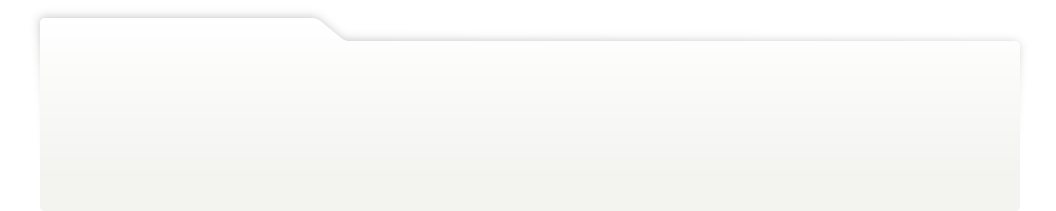
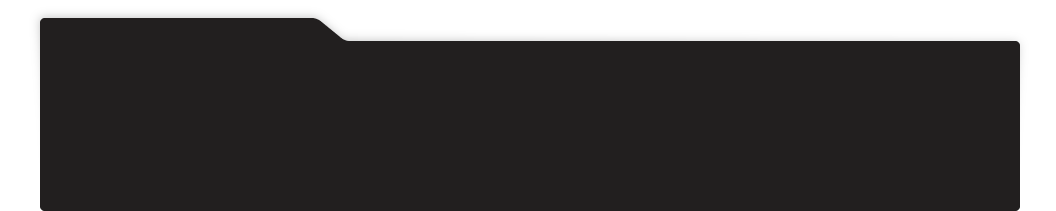
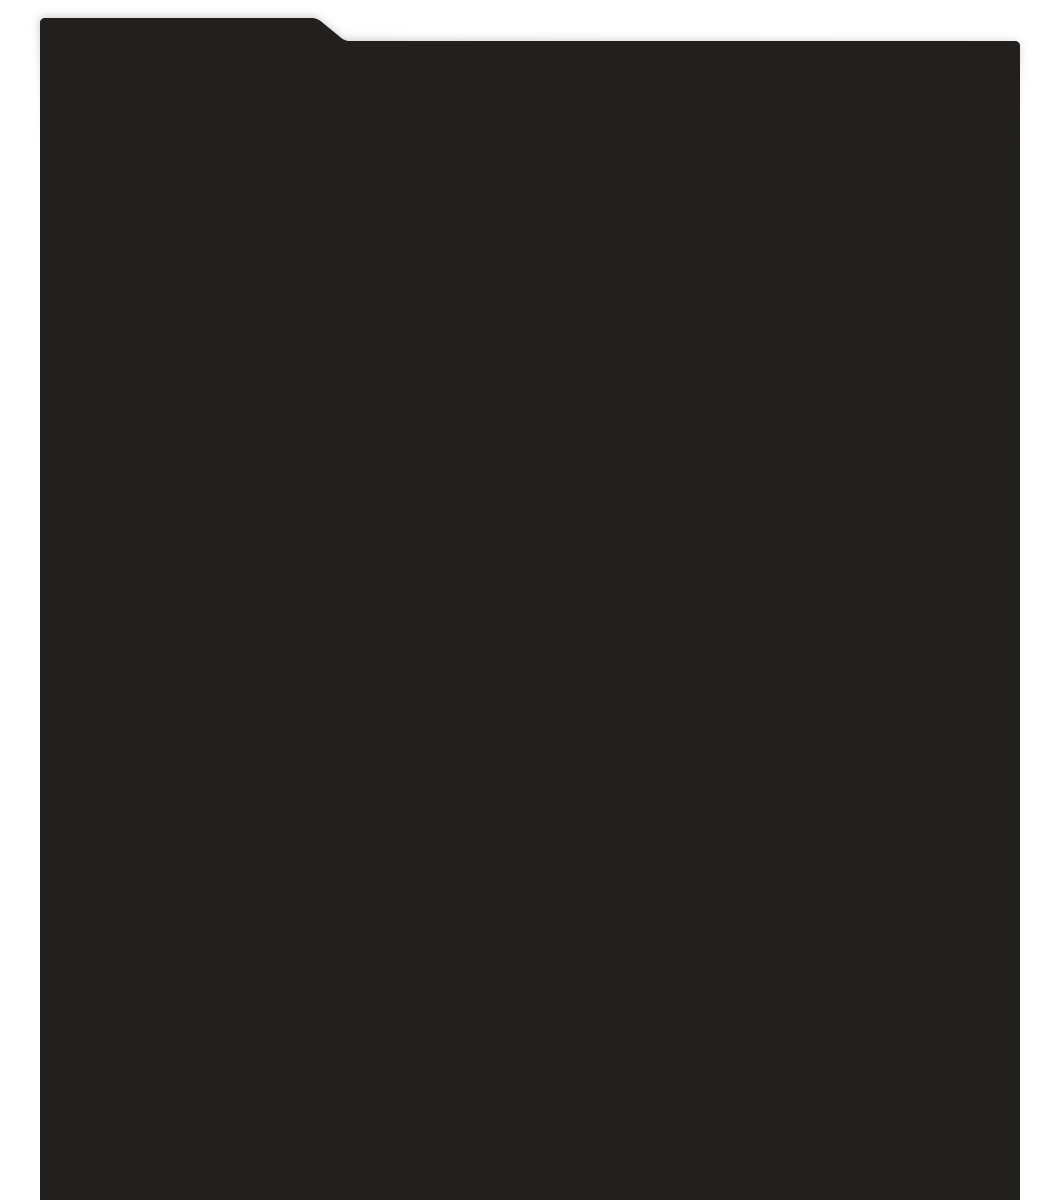
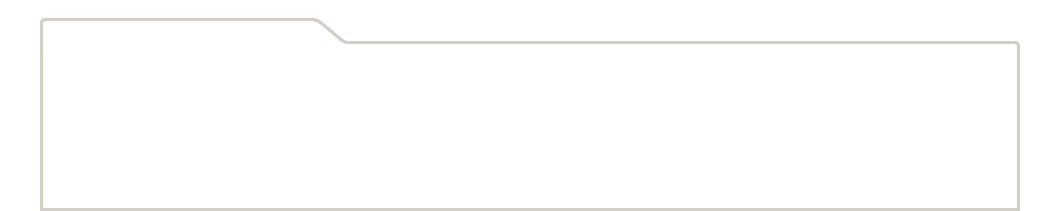
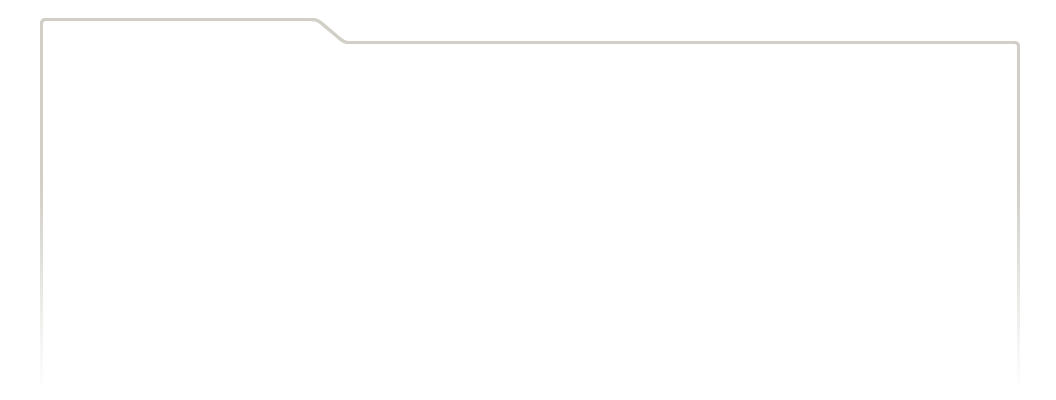
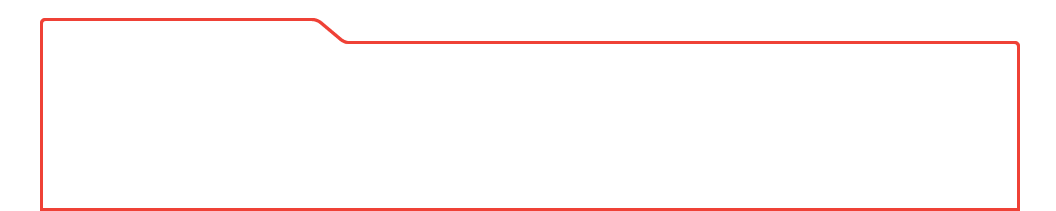
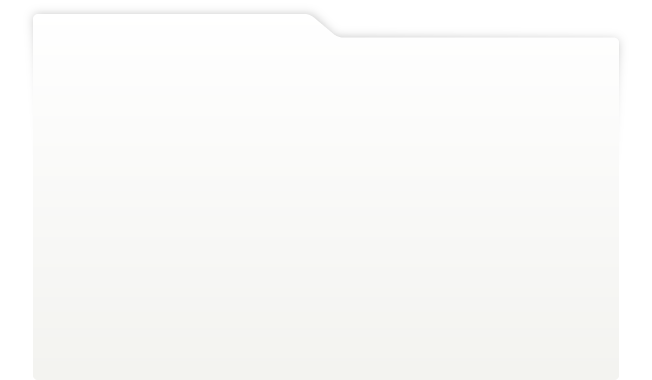
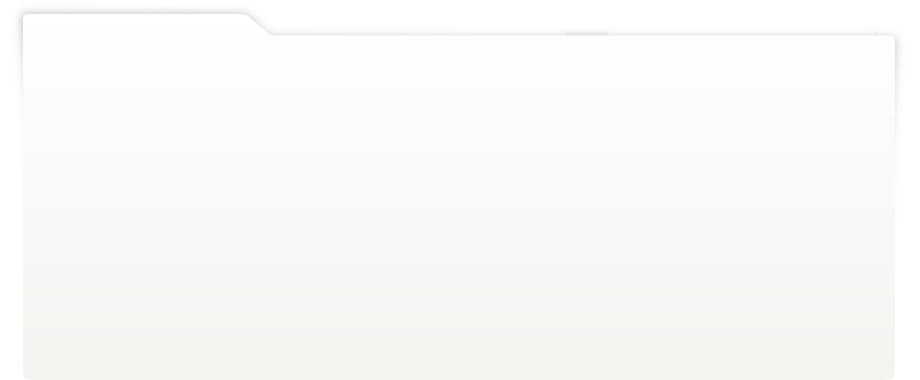
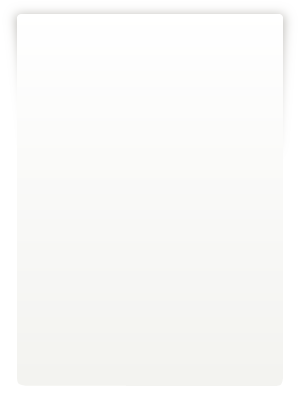
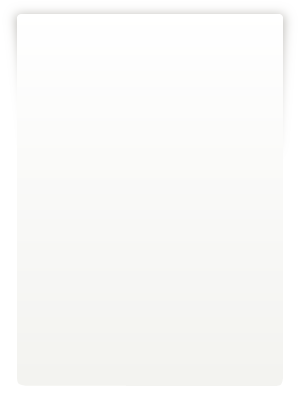
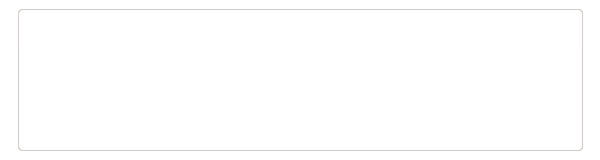
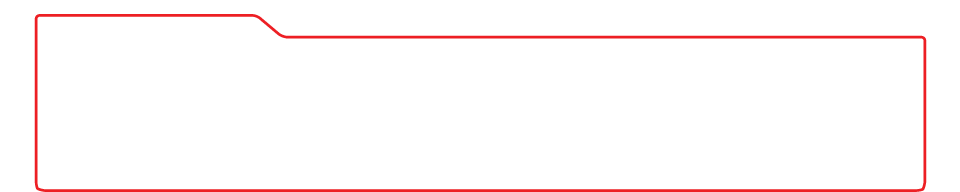
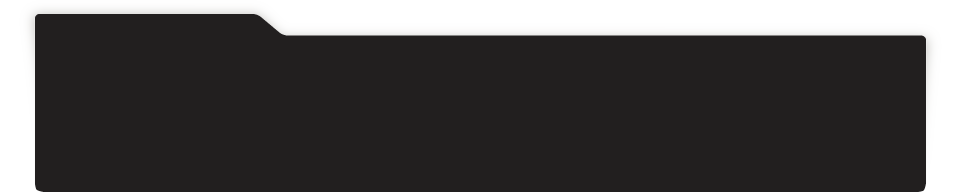
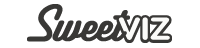
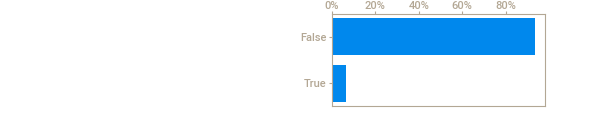
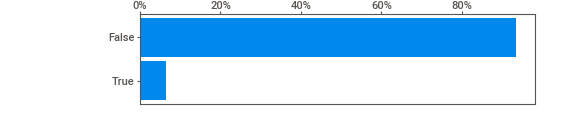
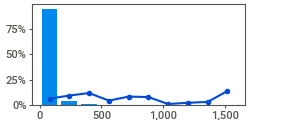
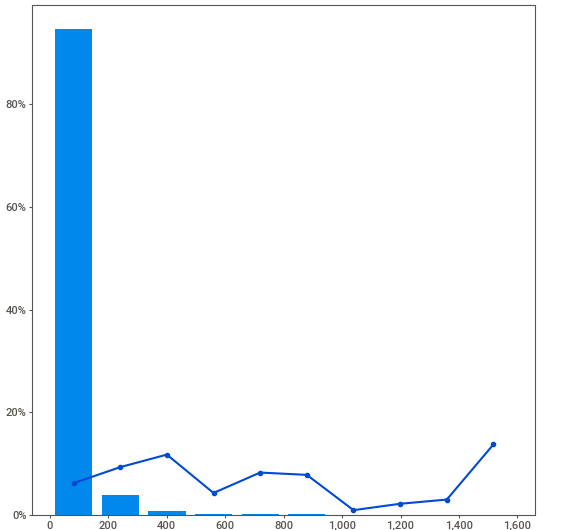
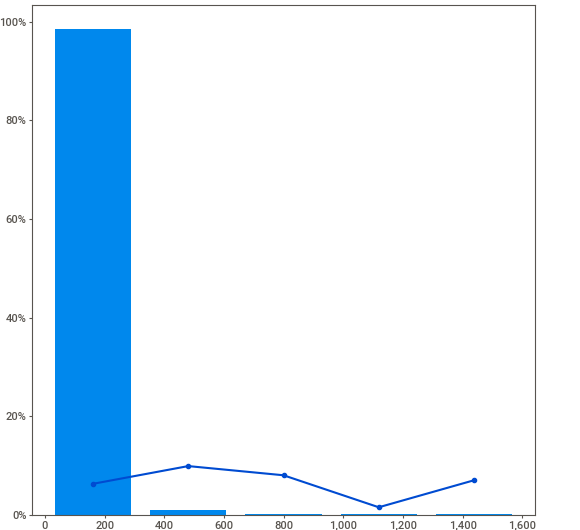
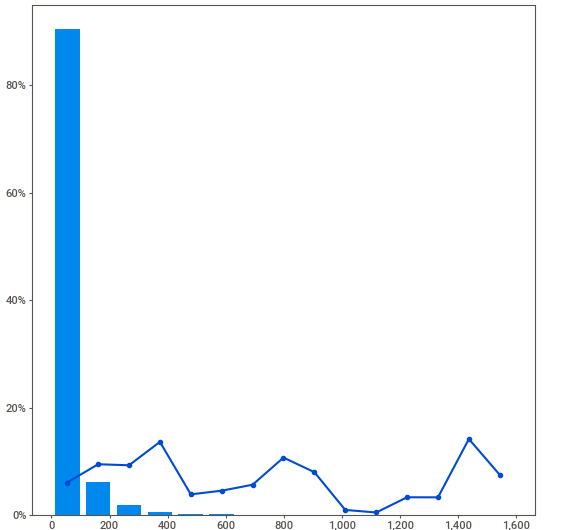
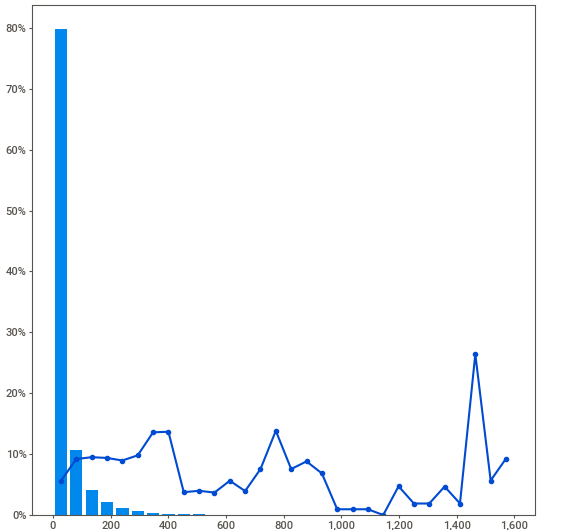
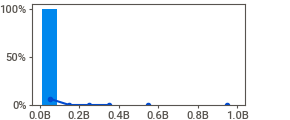
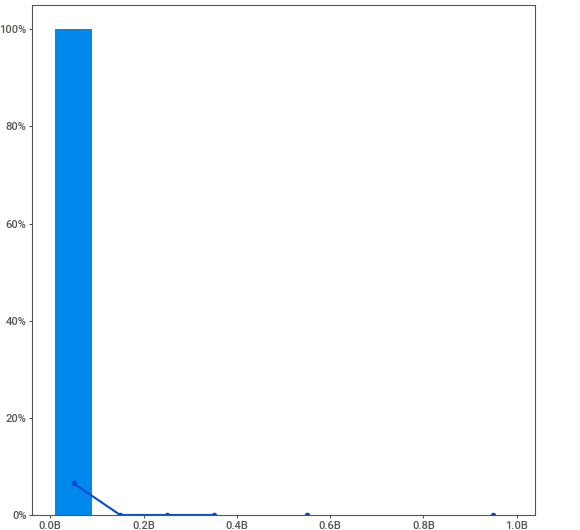
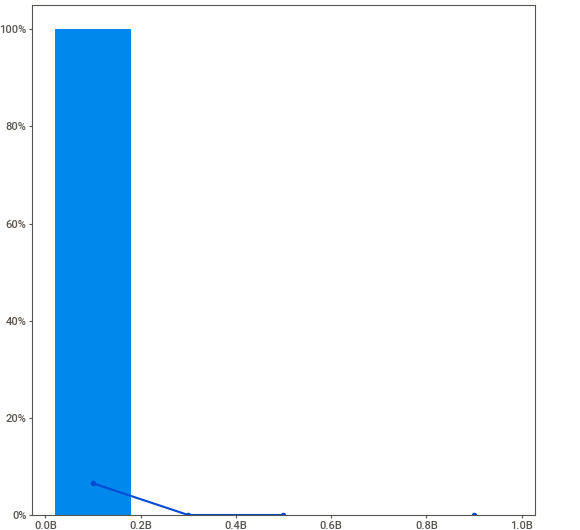
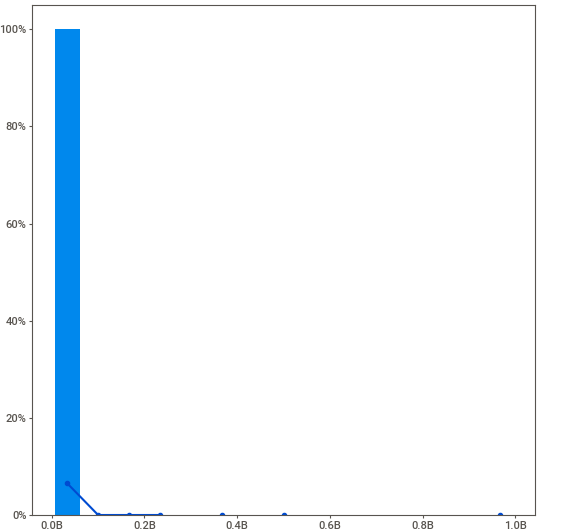
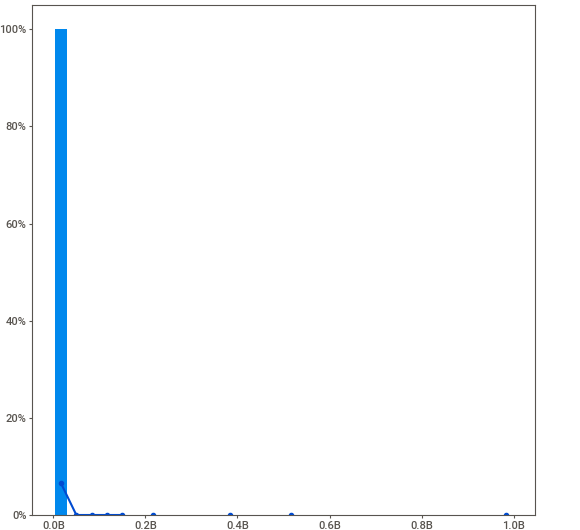
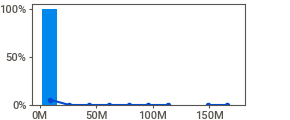
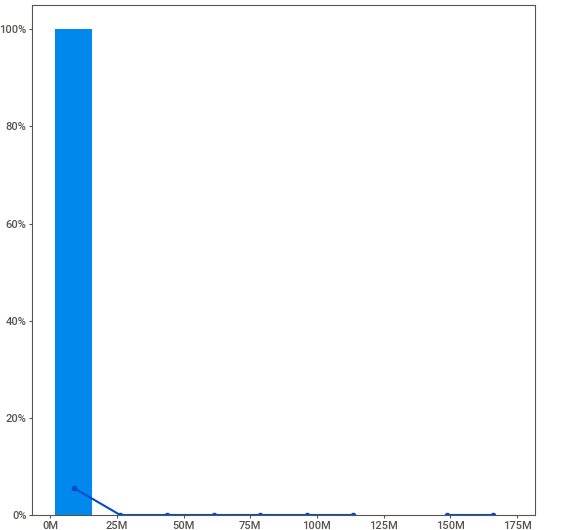
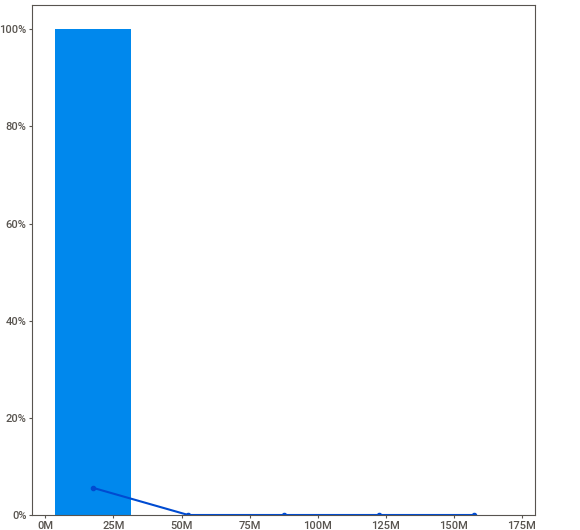
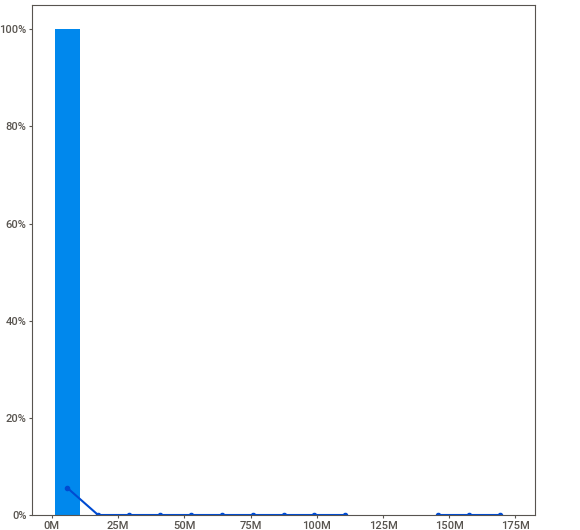
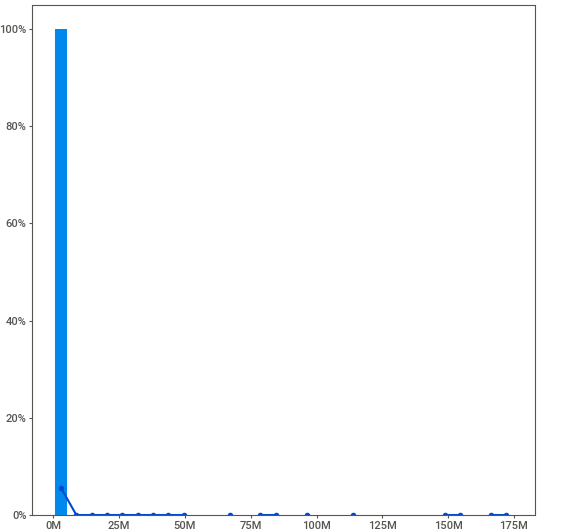
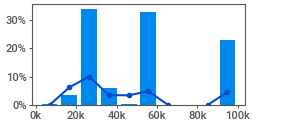
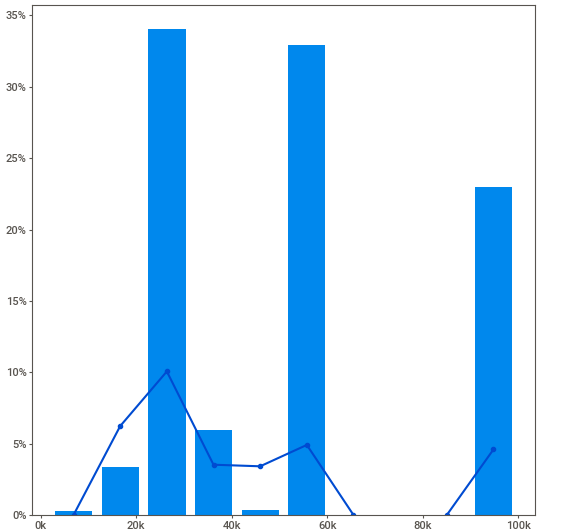
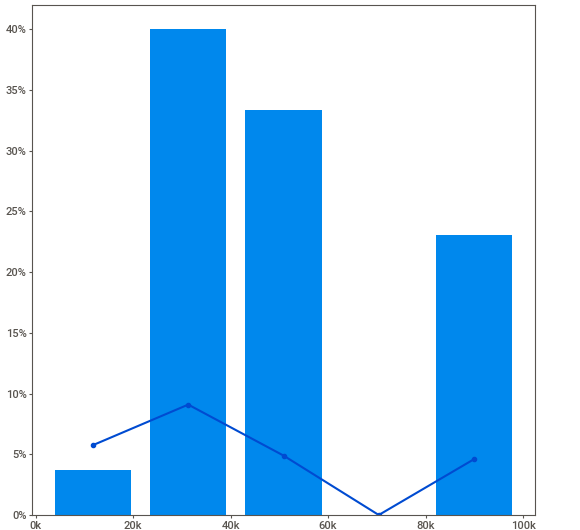
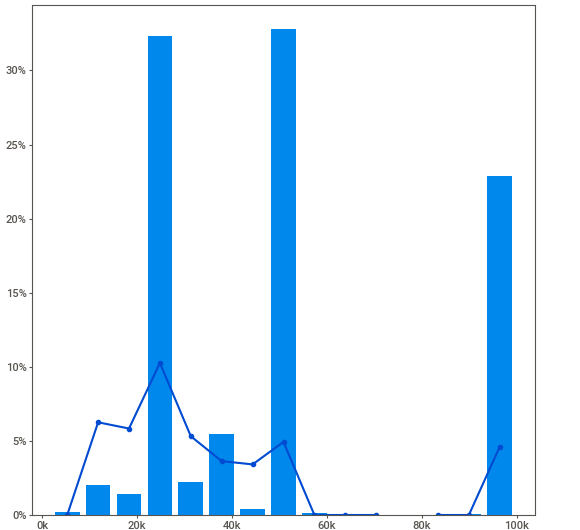
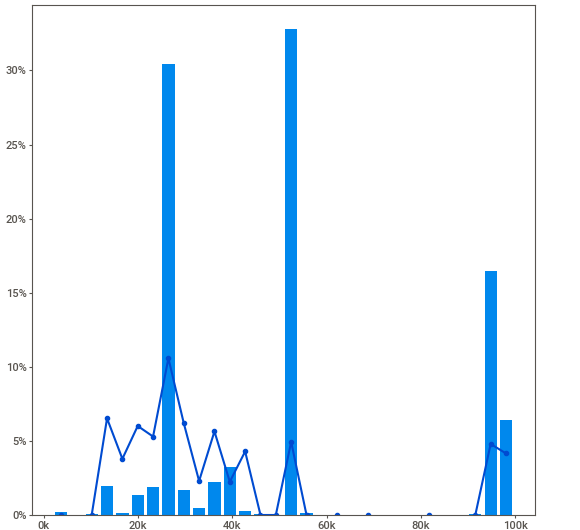
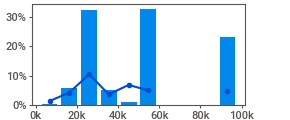
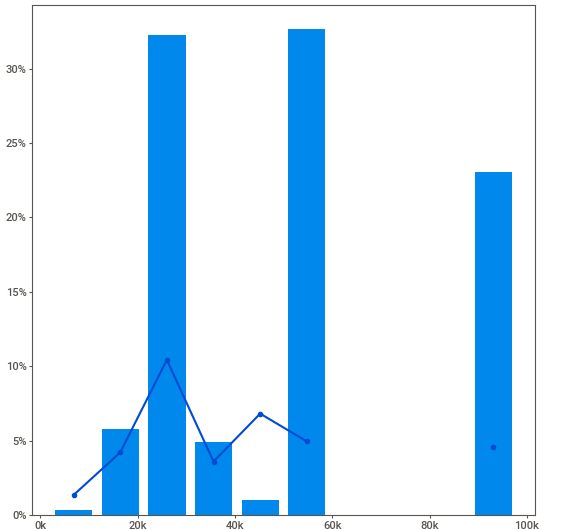
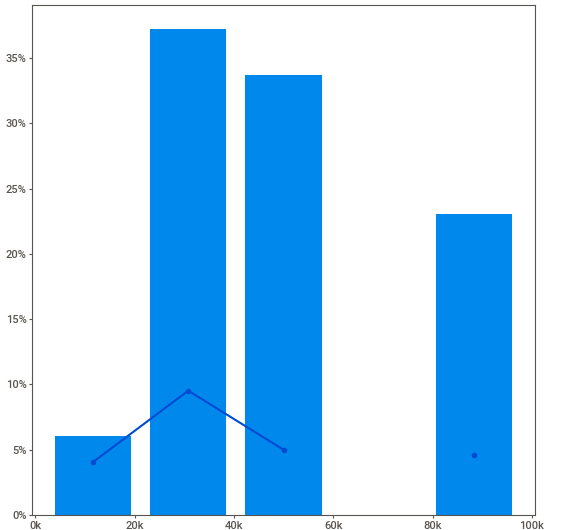
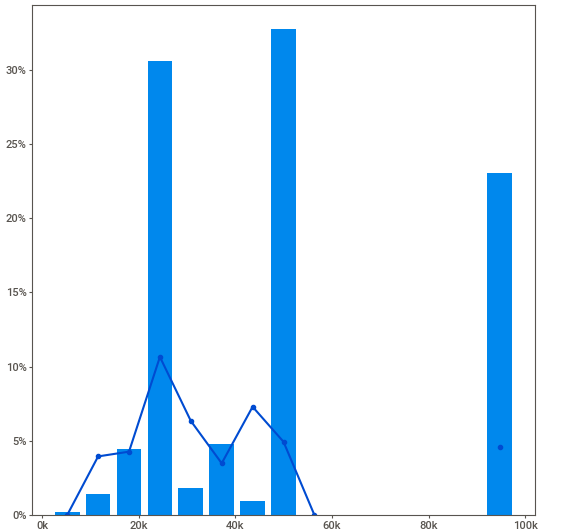
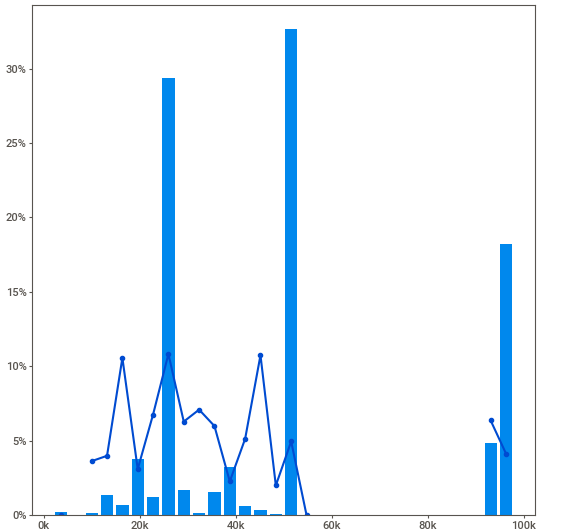
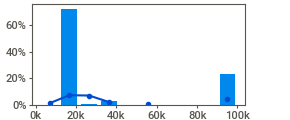
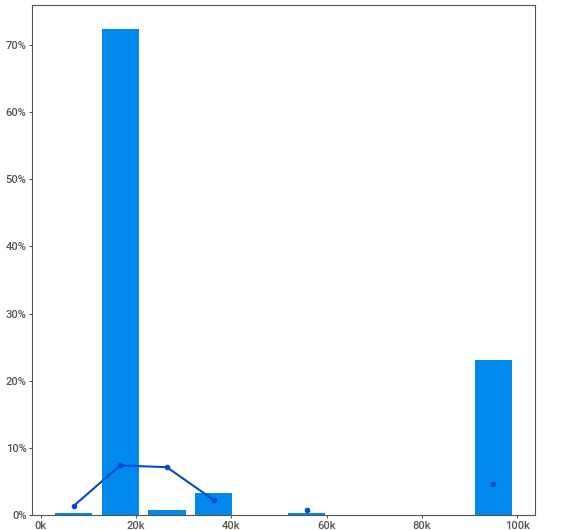
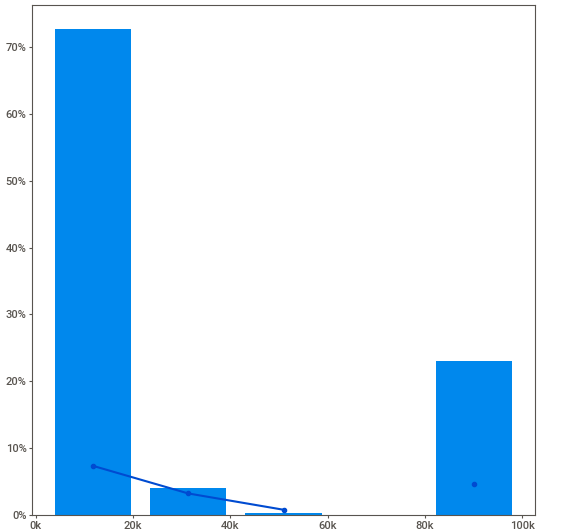
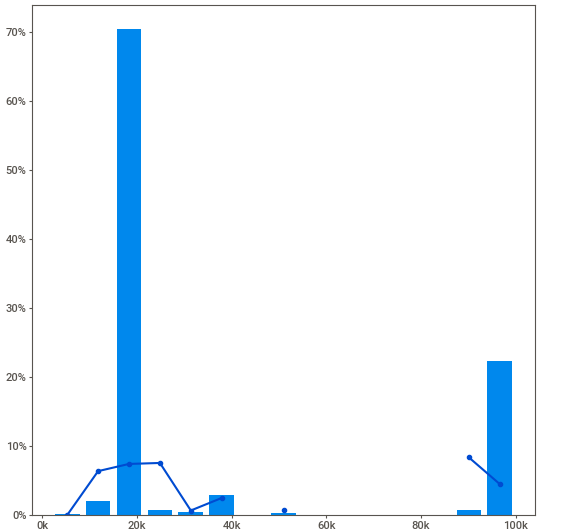
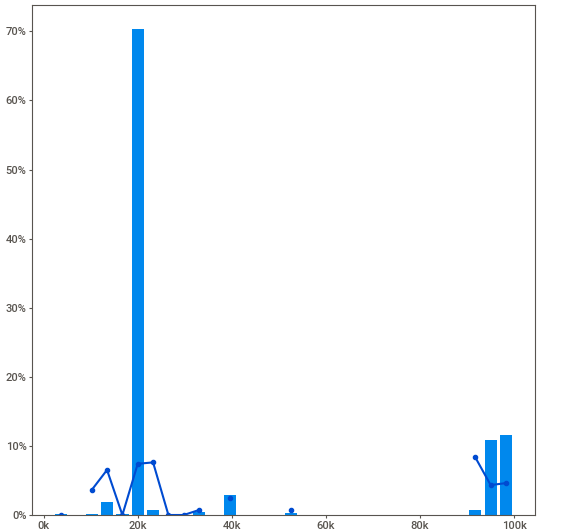
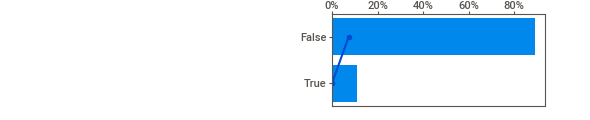
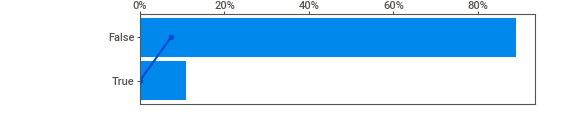
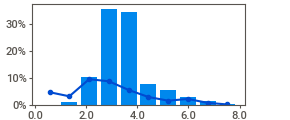
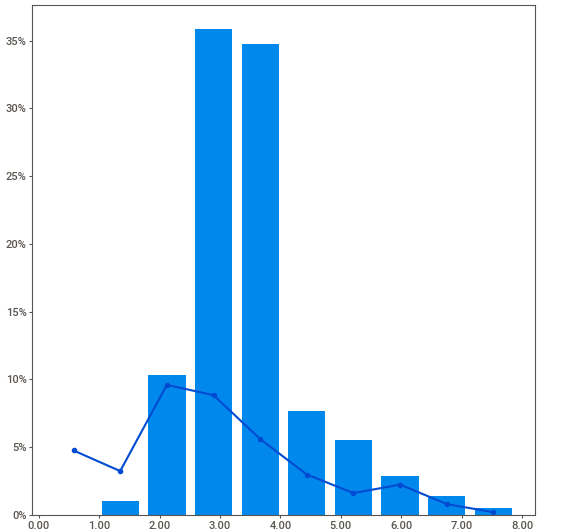
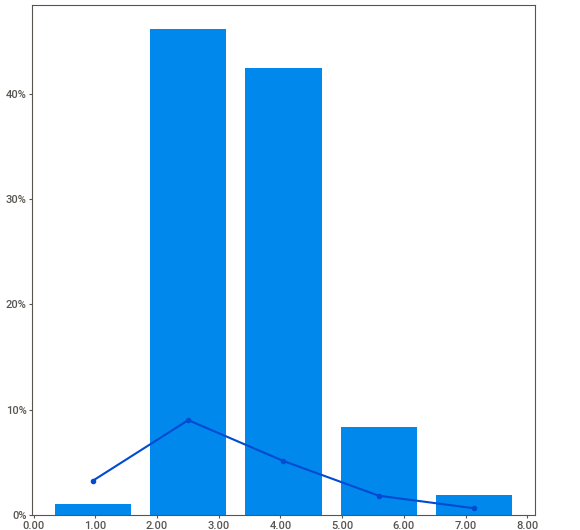
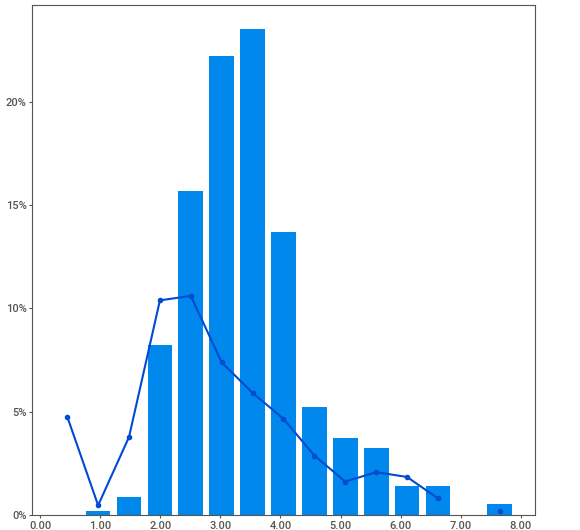
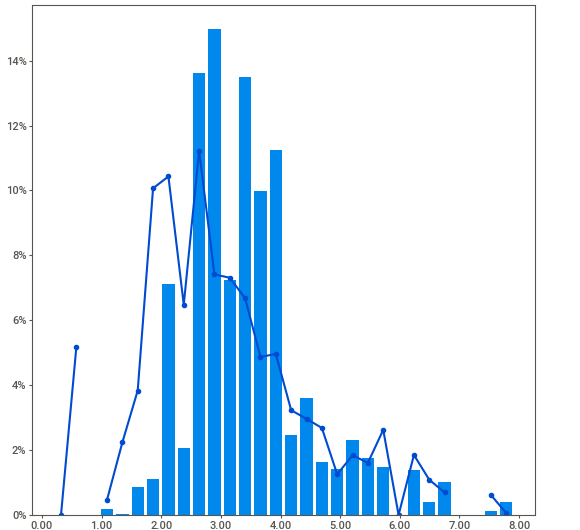
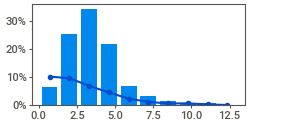
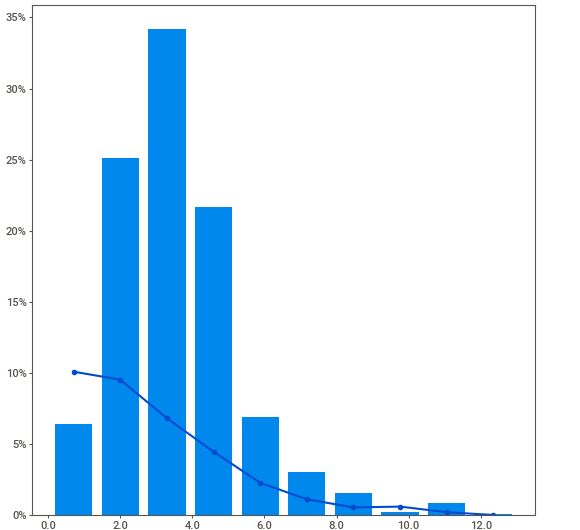
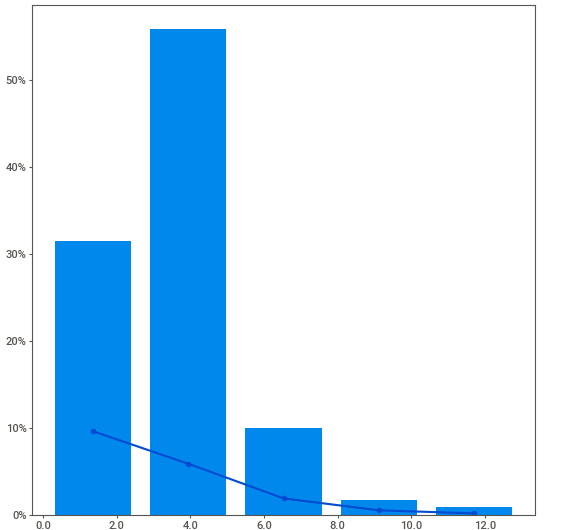
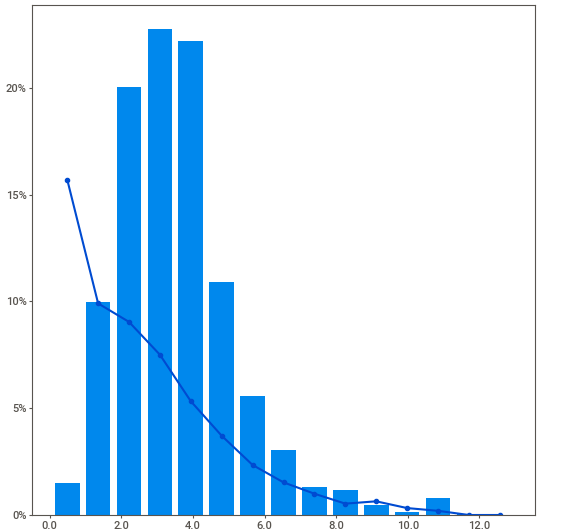
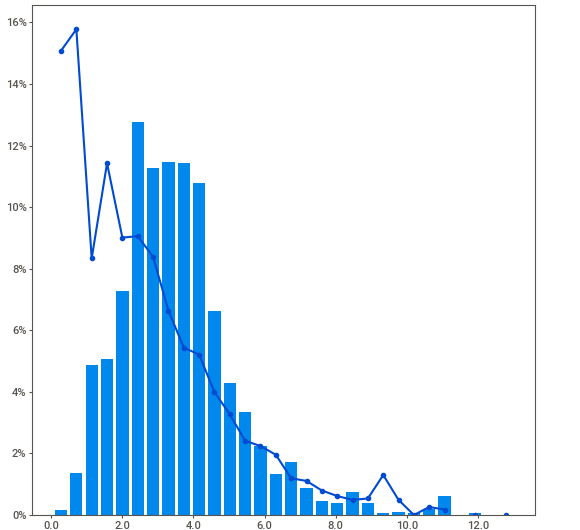
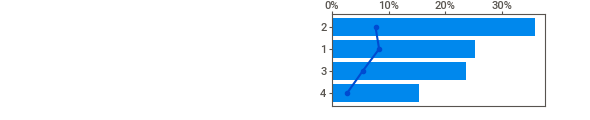
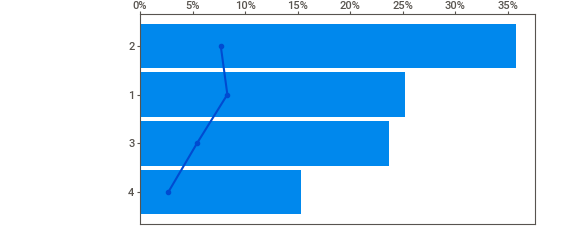
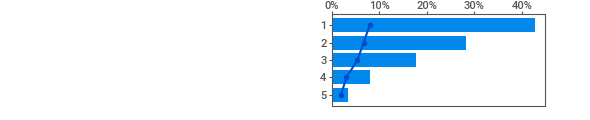
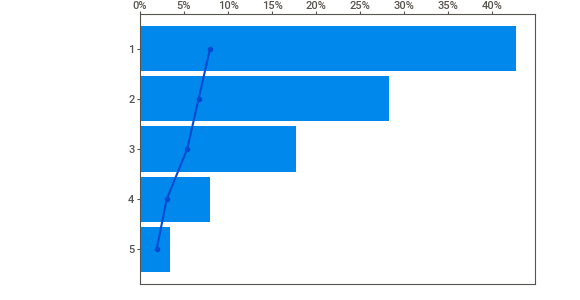
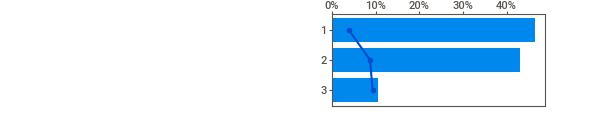
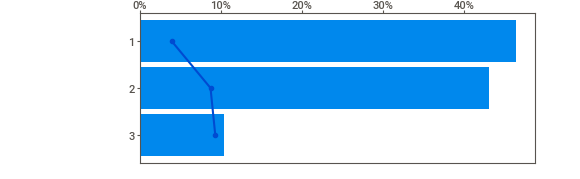
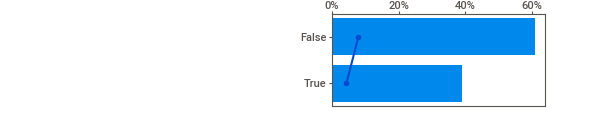
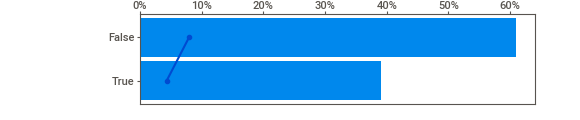
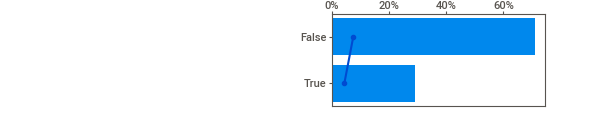
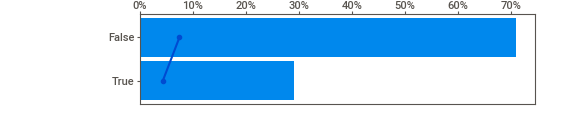
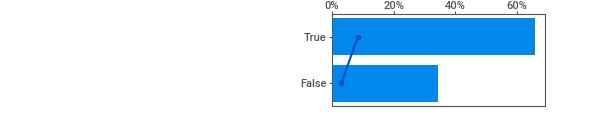
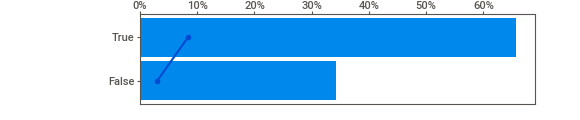
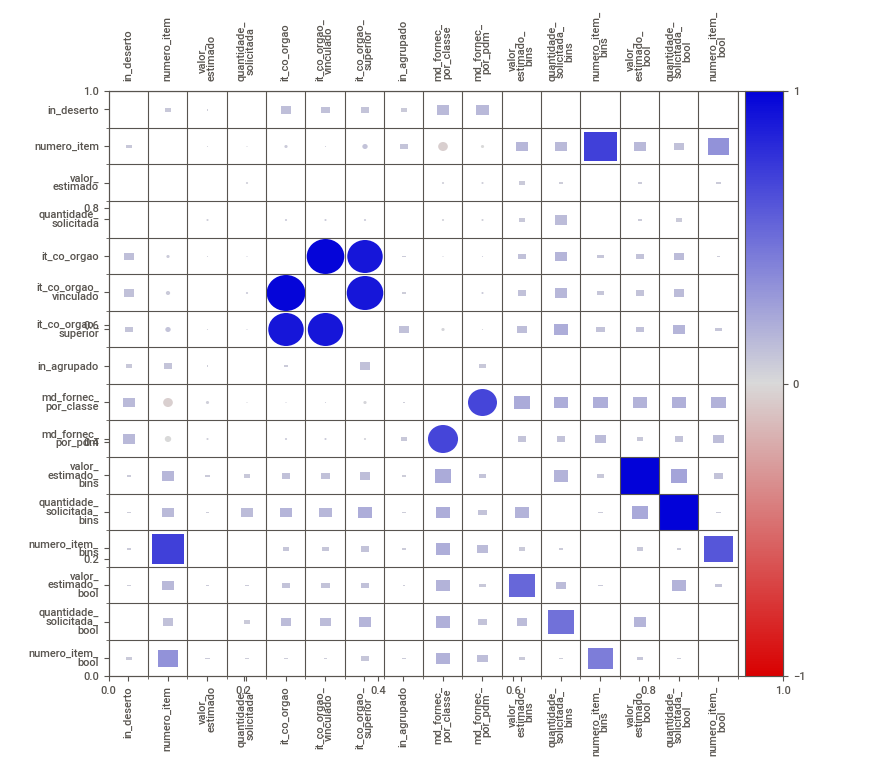
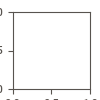

In [112]:
# SweetViz Setup
target_feature = 'in_deserto'
report = sv.analyze(df, target_feat=target_feature)

# # Print Report to Notebook
report.show_notebook(w="100%",
                     h=None, 
                     scale=None, 
                     layout='vertical',
                     filepath=None)

## Balancing Target Class with Sklearn

In [113]:
df = df_etl.copy()

# Split DataFrame into train, validation and test sets
train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

# # Separate the DataFrame into two based on the 'in_deserto' column
# train_true = train[train['in_deserto'] == True]
# train_false = train[train['in_deserto'] == False]

# # Downsample the 'df_deserto_false' DataFrame to 0.5
# # train_false_downsampled = resample(train_false,
# #                                    replace=False,
# #                                    n_samples=int(len(train_false)*0.5),
# #                                    random_state=42)

# # Downsample the 'df_deserto_false' DataFrame to 0.5
# train_false_downsampled = resample(
#     train_false,
#     replace=False,
#     n_samples=int(len(train_true)*2),
#     random_state=42,
#     )                           

# # Oversample the 'df_deserto' DataFrame
# train_true_oversampled = resample(
#     train_true,
#     replace=False,
#     n_samples=len(train_false_downsampled),
#     random_state=42,
#     )

# # Combine the DataFrames
# train_balanced = pd.concat([train_false_downsampled, train_true_oversampled])

## Export Dataframe to CSV

In [114]:
# Export DataFrames to CSV
train.to_csv('output/comprasgov_poc_item_deserto_v3_4_train.csv', index=False)
val.to_csv('output/comprasgov_poc_item_deserto_v3_4_val.csv', index=False)
test.to_csv('output/comprasgov_poc_item_deserto_v3_4_test.csv', index=False)
# train_balanced.to_csv('output/comprasgov_poc_item_deserto_v3_1_train_balanced.csv', index=False)

# ETL Functions

In [ ]:
# Load data
df = read_data_from_postgres(full_sql_query)
# df = read_data_from_postgres(train_sql_query)
# df = read_data_from_postgres(test_sql_query)



## Modeling

### AutoML with LazyPredict

In [ ]:
# Separating the target variable and rest of the data.
y = df['in_deserto']
df.drop('in_deserto',inplace=True,axis=1)
X = df

# Splitting the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =1)

clf = LazyClassifier(
    verbose=0,
    ignore_warnings=True, 
    custom_metric=None,
    )

#Training the models
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Printing the output
models

### AutoML with PyCaret

In [ ]:
from pycaret.classification import *

# Loading the data, defining the target varaible and performing normalizing using z-score
clf = setup(
    data = df,
    target = 'in_deserto',
    normalize=True,
    normalize_method='zscore',
    )

# Comparing all models
compare_models()

In [ ]:
# Creating a model
mdl = create_model('_')

# plotting the ROC Curve
plot_model(_, plot = 'auc')

# Functions

## Transformations and Feature Engineering

In [31]:
def data_etl(df):

    columns_to_ignore = ['data_hora_prevista_abertura_sp', 'situacao_compra', 'id', 'it_sg_regiao', 'in_pregao', 
                        'descricao', 'it_no_orgao', 'it_no_orgao_vinculado', 'it_no_orgao_superior', 
                        'nome_grupo_secao', 'nome_classe_divisao', 'nome_pdm_grupo']

    df = df.drop(columns_to_ignore, axis=1, inplace=False)

    # Identify boolean columns in the DataFrame
    # bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

    # Convert boolean columns to integers
    # df[bool_cols] = df[bool_cols].astype(int)

    # Identify categorical columns in the DataFrame
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    df[categorical_cols] = df[categorical_cols].apply(lambda col: LabelEncoder().fit_transform(col))

    return df

## Outliers Analysis

In [32]:
df[(np.abs(stats.zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

,numero_item,valor_estimado,quantidade_solicitada,variacao_minima_entre_lances,it_sg_uf,codigo_item_catalogo,it_in_tipo_administracao,codigo_grupo_secao,codigo_classe_divisao,codigo_pdm_grupo,...,in_orcamento_sigiloso,in_deserto,in_agrupado,in_aberto,in_srp,in_exclusivo_me_epp,in_federal,in_poder_executivo,in_percentual,in_servico
0,59,3292.14,2,1.0,SP,603638,5,84,8415,1203,...,False,False,False,False,False,True,True,True,True,False
1,60,353.08,2,1.0,SP,475757,5,65,6525,18113,...,False,False,False,False,False,True,True,True,True,False
2,61,1083.69,2,1.0,SP,390667,5,65,6532,421,...,False,False,False,False,False,True,True,True,True,False
3,62,1494.99,1,1.0,SP,397946,5,42,4240,1377,...,False,False,False,False,False,True,True,True,True,False
4,1,9992.42,1,10.0,MT,3212,3,6,64,643,...,False,False,False,False,False,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216671,54,329.92,2,1.0,SP,440398,5,42,4240,7495,...,False,True,False,False,False,True,True,True,True,False
216672,55,329.92,1,1.0,SP,402131,5,42,4240,7495,...,False,True,False,False,False,True,True,True,True,False
216673,56,124.64,1,1.0,SP,449179,5,42,4240,7495,...,False,True,False,False,False,True,True,True,True,False
216674,57,70.00,2,1.0,SP,459483,5,72,7210,19710,...,False,True,False,False,False,True,True,True,True,False


In [16]:
def remove_outliers(df):
    return df[(np.abs(stats.zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

## Models and Metrics

In [ ]:
# AutoML for Model Selection and Ranking
# def run_automl(X_train, y_train):
#     tpot = TPOTClassifier(generations=2, population_size=20, verbosity=2)
#     tpot.fit(X_train, y_train)
#     return tpot

# Train, Test, and Evaluate Machine Learning Models
def train_test_evaluate_models(X, y, X_val, y_val):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Run AutoML
    # automl_model = run_automl(X_train, y_train)
    
    models = {
        # "AutoML": automl_model,
        "RandomForest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(),
        "LightGBM": LGBMClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0)
    }
    
    metrics = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Validate with external CSV
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        metrics[name] = {
            'Test Accuracy': accuracy,
            'Validation Accuracy': val_accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        }
        
        print(f"{name} Model Metrics:")
        print(f"Test Accuracy: {accuracy}")
        print(f"Validation Accuracy: {val_accuracy}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
    return metrics

# Main

In [36]:
if __name__ == "__main__":
    # Reading Data from PostgreSQL
    df = read_data_from_postgres(train_sql_query)
    
    # ETL Operations
    df = data_etl(df)
    
    # Remove Outliers
    df = remove_outliers(df)
    
    # Prepare Data for Models
    X = df.drop('in_deserto', axis=1)  # 'in_deserto' is the target attribute
    y = df['in_deserto']
    
    # Read Validation Data from PostgreSQL
    df_val = read_data_from_postgres(test_sql_query)
    df_val = data_etl(df_val)

    X_val = df_val.drop('in_deserto', axis=1)
    y_val = df_val['in_deserto']
    
    # Train, Test, and Evaluate Models
    metrics = train_test_evaluate_models(X, y, X_val, y_val)
    
    # Comparative Metrics
    print("\nComparative Metrics:")
    for name, metric in metrics.items():
        print(f"{name} - Test Accuracy: {metric['Test Accuracy']}, Validation Accuracy: {metric['Validation Accuracy']}")

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.924659236915527

Generation 2 - Current best internal CV score: 0.9279395514165222

Best pipeline: KNeighborsClassifier(RobustScaler(input_matrix), n_neighbors=49, p=1, weights=distance)


Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9252158290297474

Generation 2 - Current best internal CV score: 0.9281941600882753

Best pipeline: KNeighborsClassifier(MinMaxScaler(input_matrix), n_neighbors=15, p=1, weights=distance)
AutoML Model Metrics:
Test Accuracy: 0.9304627919094312
Validation Accuracy: 0.9133812303547373
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.98      0.96     38493
        True       0.69      0.39      0.50      3729

    accuracy                           0.93     42222
   macro avg       0.82      0.69      0.73     42222
weighted avg       0.92      0.93      0.92     42222

RandomForest Model Metrics:
Test Accuracy: 0.9388944152337644
Validation Accuracy: 0.93242029636282
Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     38493
        True       0.81      0.41      0.54      3729

    accuracy                 

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[False  True] and y_pred=['False' 'True']. Make sure that the predictions provided by the classifier coincides with the true labels.